# Imports

In [1]:
from waveFOM import *
from ROM import *
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
np.random.seed(0)


In [2]:
"""Set the matplotlib configuration."""
plt.rcParams.update(plt.rcParamsDefault)
plt.rc("figure", dpi=300)
plt.rc("font", size=14, family="serif")
plt.rc("legend", frameon=False)
plt.rc("text", usetex=True)
plt.rc("text.latex", preamble=r"\usepackage{amsmath}")


# Experiment parameters

In [3]:
# Number of nodes in the spatial grid 
N = 60
# Wave speed
c = 1
# Total number of independent initial conditions sampled (training + testing)
Ns = 150
# Proportion of Ns to be set aside for testing
testFrac = 0.2
# Time horizon
Tf = 2*np.pi
# FOM object
FO = waveFOM(N=N)

# Case with time-invariant PDE parameters

## (a) $\gamma_1 = 0.25 = \gamma_2$

In [4]:
gamma_p = 0.25
gamma_q = 0.25
R_true = -gamma_q*np.eye(N)
K_true0 = c**2*FO.Dmat@FO.Dmat
trainIP, testIP = FO.create_grand_data_tensor(Ns, Tf, c, gamma_q, gamma_p, test_size=testFrac, atol=1e-12)

In [ ]:
dt = 0.015625
Nt = int(Tf / dt)
t_eval = np.linspace(0, Tf, Nt + 1)
train = np.array([j(t_eval) for j in trainIP])
test = np.array([j(t_eval) for j in testIP])
qTrain, pTrain = np.split(train, 2, axis=1)
qTest, pTest = np.split(test, 2, axis=1)
qTrainDeriv = 1/dt * (qTrain[:,:,1:] - qTrain[:,:,0:-1])

In [11]:
rom = ROM_Partial_Data(qTrain, pTrain, qTrainDeriv, dt)
rom.train(constantR=True)
sol = rom.solve(qTest[:,:,0], pTest[:,:,0], dt, Nt)
err = np.linalg.norm(sol - qTest)/np.linalg.norm(qTest)
print(err)

2.29948019559421e-12


In [12]:
rom = ROM_Full_Data(qTrain, pTrain, qTrainDeriv, dt)
rom.train()
sol = rom.solve(qTest[:,:,0], pTest[:,:,0])
err = np.linalg.norm(sol - qTest)/np.linalg.norm(qTest)
err

np.float64(2.2988804898644234e-12)

# Case with time-varying PDE parameters

## (a) $\gamma_1 = 0.5\sin^2 t, \gamma_2 = 1$

In [14]:
gamma_q = lambda t: 0.5*np.sin(t)**2
gamma_p = lambda t: 1
c = 1

K_true0 = c**2*FO.Dmat@FO.Dmat
trainIP, testIP = FO.create_grand_data_tensor(Ns, Tf, c, gamma_q, gamma_p, test_size=testFrac, atol=1e-12)

In [15]:
dt = 0.015625
Nt = int(Tf / dt)
t_eval = np.linspace(0, Tf, Nt + 1)
train = np.array([j(t_eval) for j in trainIP])
test = np.array([j(t_eval) for j in testIP])
qTrain, pTrain = np.split(train, 2, axis=1)
qTest, pTest = np.split(test, 2, axis=1)
qTrainDeriv = 1/dt * (qTrain[:,:,1:] - qTrain[:,:,0:-1])

In [16]:
rom = ROM_Partial_Data(qTrain, pTrain, qTrainDeriv, dt)
rom.train(constantR=False, regR=0, regK=0)
sol = rom.solve(qTest[:,:,0], pTest[:,:,0], dt, Nt)
err = np.linalg.norm(sol - qTest)/np.linalg.norm(qTest)
err

np.float64(0.023856710206366573)

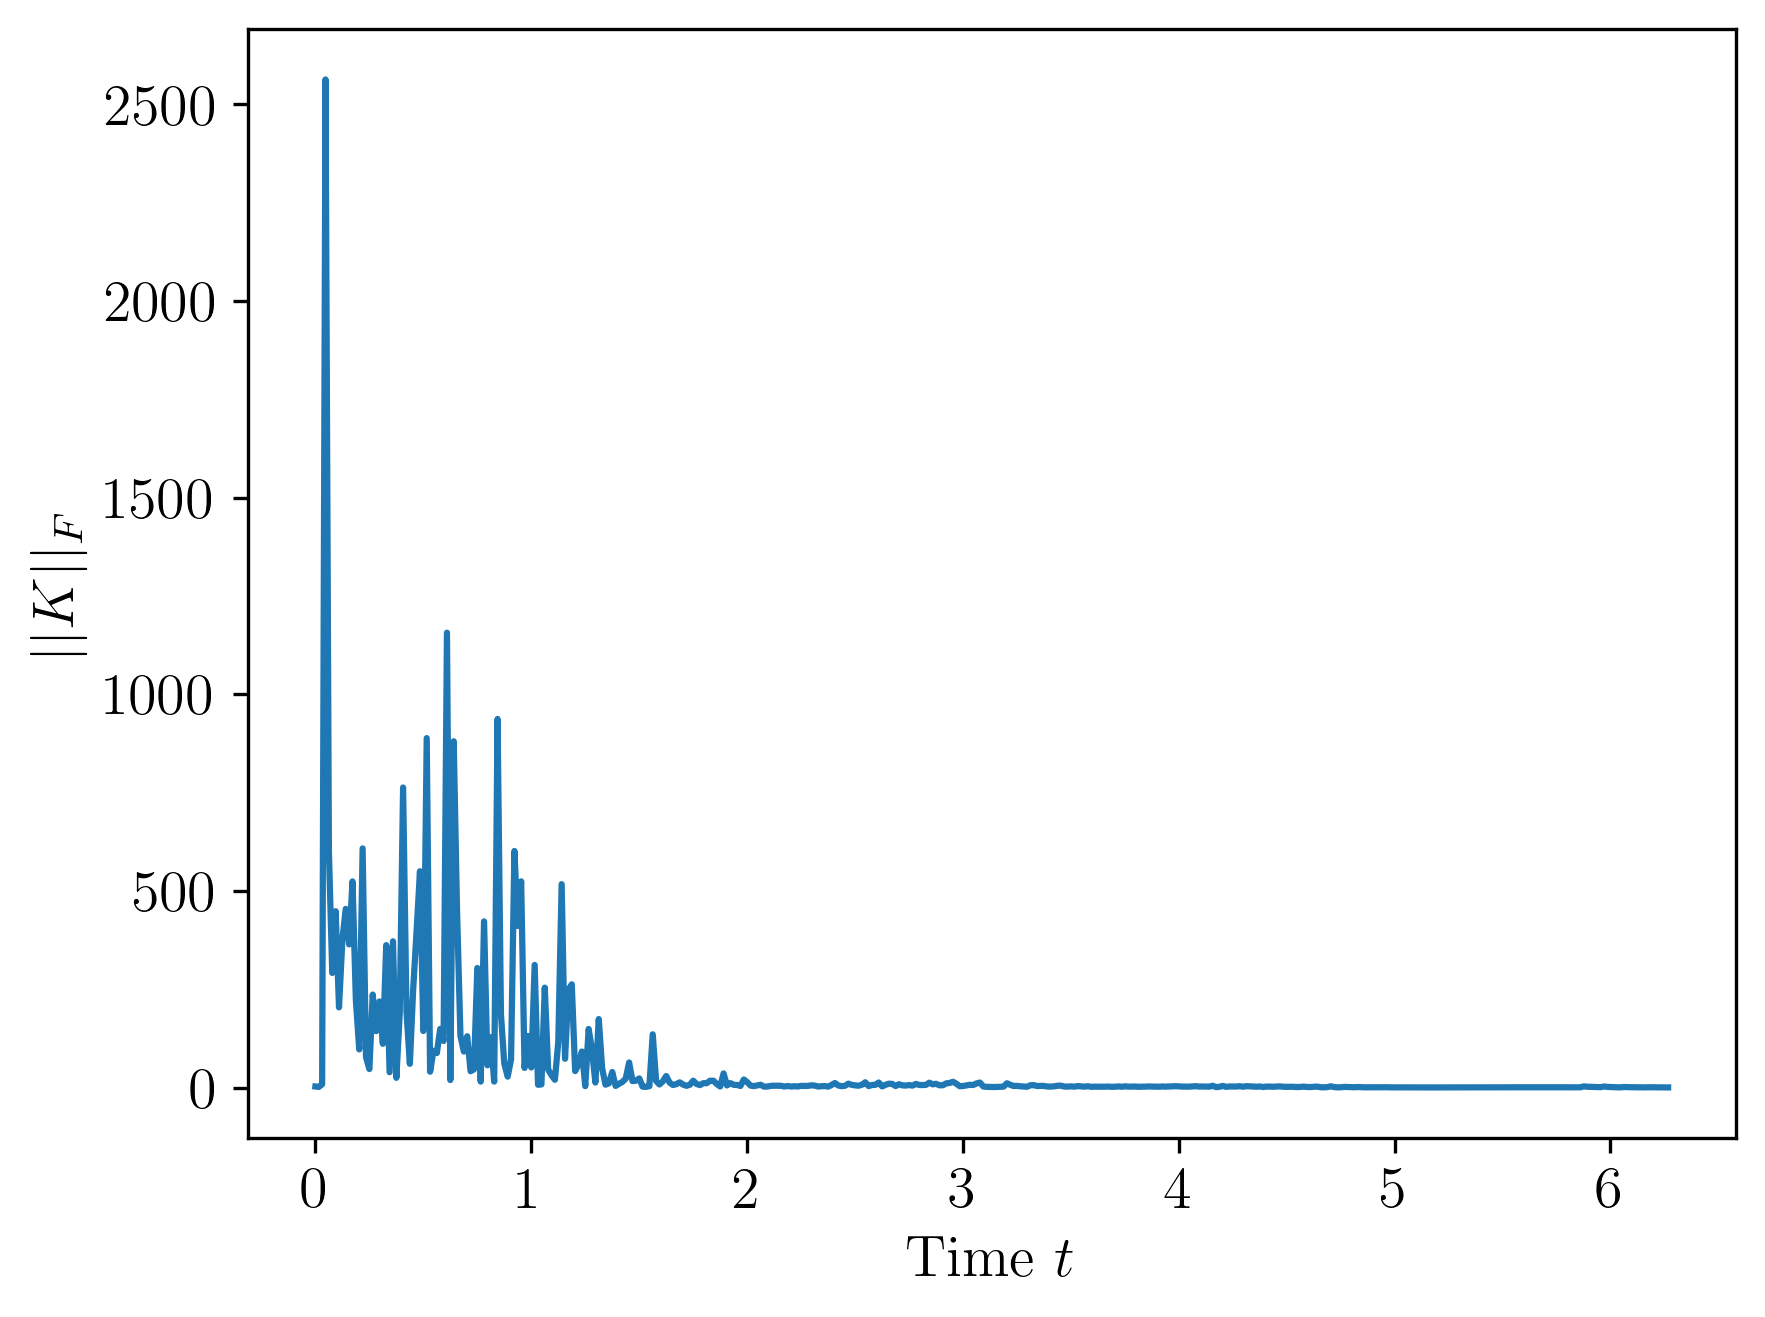

In [17]:
Knorms = [np.linalg.norm(rom.K[:,:,i]) for i in range(rom.K.shape[-1])]
plt.figure()
plt.plot(t_eval[:-1], Knorms)
plt.xlabel(r"Time $t$")
plt.ylabel(r"$||K||_F$")
plt.show()

In [18]:
reg = [0, 1e-8, 1e-4, 1e-2, 1]
errors = {}
rom = ROM_Partial_Data(qTrain, pTrain, qTrainDeriv, dt)
for regR, regK in product(reg, reg):
        rom.train(constantR=False, regR=regR, regK=regK)
        sol = rom.solve(qTest[:,:,0], pTest[:,:,0], dt, Nt)
        err = np.linalg.norm(sol - qTest)/np.linalg.norm(qTest)
        errors[(regR, regK)] = err
# Prepare header
header = r"\reg_R \\ \reg_K | " + " | ".join(f"{k:>10.1e}" for k in reg)
print(header)
print("-" * len(header))
# Print each row
for regR in reg:
    row = f"{regR:>12.1e} | "
    for regK in reg:
        err = errors[(regR, regK)]
        row += f"{err:>10.2e} | "
    print(row)

\reg_R \\ \reg_K |    0.0e+00 |    1.0e-08 |    1.0e-04 |    1.0e-02 |    1.0e+00
---------------------------------------------------------------------------------
     0.0e+00 |   2.39e-02 |   1.34e-11 |   2.15e-11 |   1.32e-11 |   9.91e-12 | 
     1.0e-08 |   2.04e-12 |        nan |   1.51e+31 |   9.82e+33 |   4.09e+39 | 
     1.0e-04 |   2.04e-12 |   2.72e-12 |        nan |  7.27e+132 |   1.27e+96 | 
     1.0e-02 |   2.04e-12 |   2.72e-12 |   1.09e-04 |        inf |   1.08e+85 | 
     1.0e+00 |   2.04e-12 |   2.72e-12 |   1.22e-04 |   6.76e-03 |   2.14e+47 | 


## (c) $\gamma_1 = 0.5 \cos t, \gamma_2 = 1 + \sin(t)$

In [19]:
gamma_q = lambda t: 0.5*np.cos(t)
gamma_p = lambda t: 1 + np.sin(t)
c = 1
trainIP, testIP = FO.create_grand_data_tensor(Ns, Tf, c, gamma_q, gamma_p, test_size=testFrac, atol=1e-12)

In [23]:
dt = 0.015625
Nt = int(Tf / dt)
t_eval = np.linspace(0, Tf, Nt + 1)
train = np.array([j(t_eval) for j in trainIP])
test = np.array([j(t_eval) for j in testIP])
qTrain, pTrain = np.split(train, 2, axis=1)
qTest, pTest = np.split(test, 2, axis=1)
qTrainDeriv = 1/dt * (qTrain[:,:,1:] - qTrain[:,:,0:-1])

In [24]:
reg = [0, 1e-8, 1e-4, 1e-2, 1]
errors = {}
rom = ROM_Partial_Data(qTrain, pTrain, qTrainDeriv, dt)
for regR, regK in product(reg, reg):
        rom.train(constantR=False, regR=regR, regK=regK)
        sol = rom.solve(qTest[:,:,0], pTest[:,:,0], dt, Nt)
        err = np.linalg.norm(sol - qTest)/np.linalg.norm(qTest)
        errors[(regR, regK)] = err
# Prepare header
header = r"\reg_R \\ \reg_K | " + " | ".join(f"{k:>10.1e}" for k in reg)
print(header)
print("-" * len(header))
# Print each row
for regR in reg:
    row = f"{regR:>12.1e} | "
    for regK in reg:
        err = errors[(regR, regK)]
        row += f"{err:>10.2e} | "
    print(row)

/Users/arjunveejay/Documents/Code/Public repos/MZ-linear-model-reduction/ROM.py:327: RuntimeWarning: invalid value encountered in add
  rhs += dt**2 * (sol[..., k]+sol[..., k+1])/2 @ self.K[..., n-k].T


\reg_R \\ \reg_K |    0.0e+00 |    1.0e-08 |    1.0e-04 |    1.0e-02 |    1.0e+00
---------------------------------------------------------------------------------
     0.0e+00 |   1.26e-05 |   7.92e-10 |   4.08e-10 |   2.60e-10 |   9.04e-10 | 
     1.0e-08 |   1.60e-12 |        nan |   5.46e+15 |   2.16e+18 |   1.16e+24 | 
     1.0e-04 |   1.59e-12 |   1.80e-12 |        nan |   1.52e+68 |   2.29e+67 | 
     1.0e-02 |   1.59e-12 |   1.79e-12 |   5.26e-05 |        inf |   6.01e+76 | 
     1.0e+00 |   1.59e-12 |   1.79e-12 |   5.83e-05 |   1.99e-03 |   1.62e+14 | 
